In [1]:
import os
import torch
import pickle
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm.auto import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import cv2
from torchvision import models
from sklearn import preprocessing
from tqdm import tqdm
import random
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
from torch.utils.data import Subset
from torch.utils.data import ConcatDataset

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
dataset = datasets.ImageFolder('/kaggle/input/stanford-dogs-dataset/images/Images')
dataset_len = len(dataset)

In [4]:
def load_text_file(path):
        with open(path, 'r') as f:
            text = f.read()
        return text

In [5]:
annotation = datasets.DatasetFolder('/kaggle/input/stanford-dogs-dataset/annotations/Annotation', loader=load_text_file, extensions=('',))

In [6]:
gan_dataset = datasets.ImageFolder('/kaggle/input/gan-stanford-dogs/images')
gan_dataset_len = len(gan_dataset)

In [7]:
train_size = int(dataset_len*0.7)
test_size = int(dataset_len*0.1)
val_size = int(dataset_len*0.2)

In [8]:
def train_test_val_split():
  g = torch.Generator()
  g.manual_seed(42)
  indices = list(range(dataset_len))
  np.random.seed(11)
  np.random.shuffle(indices)

  test_index = indices[:test_size]
  train_index = indices[test_size:test_size+train_size]
  val_index = indices[-val_size:]

  train_sampler=SubsetRandomSampler(train_index, generator=g)
  val_sampler=SubsetRandomSampler(val_index, generator=g)
  test_sampler=SubsetRandomSampler(test_index, generator=g)

  return train_sampler,val_sampler,test_sampler,indices, train_index

In [9]:
train_sampler,val_sampler,test_sampler,indices, train_index = train_test_val_split()

In [42]:
class CustomImageDataset(Dataset):
    def __init__(self, dataset, annotation, train_index, transform=None, normalize=None):
        self.dataset = dataset
        self.annotation = annotation
        self.dataset_len = len(dataset)
        self.transform = transform
        self.normalize = normalize
        self.train_index = train_index
        # self.dataset = np.transpose(dataset[0], (1, 2, 0))        

    def __len__(self):
        return self.dataset_len
    
    def load_text_file(path):
        with open(path, 'r') as f:
            text = f.read()
        return text

    def __getitem__(self, idx):
        
        image, index = self.dataset[idx]
        w,h = image.size
        
#         if (idx in self.train_index):
#             text = annotation[idx][0]

#             xml_root = ET.fromstring(text)
            
#             width = int(xml_root.find('size/width').text)
#             height = int(xml_root.find('size/height').text)
#             xmin = int(xml_root.find('object/bndbox/xmin').text)
#             xmax = int(xml_root.find('object/bndbox/xmax').text)
#             ymin = int(xml_root.find('object/bndbox/ymin').text)
#             ymax = int(xml_root.find('object/bndbox/ymax').text)
            
#             bbox = (xmin, ymin, xmax, ymax)

#             annotated_image = Image.new("RGB", (width, height), color=(255, 255, 255))

#             annotated_image.paste(image, (0, 0))

#             draw = ImageDraw.Draw(annotated_image)
#             thickness = 5
#             draw.rectangle(bbox, outline="red", width=thickness)
            
#             image = annotated_image
#             plt.imshow(image)
            
        
        if w < h:
            resized_image = image.resize((224, int(224 * h / w)))
        else:
            resized_image = image.resize((int(224 * w / h), 224))
        w,h = resized_image.size
        image = resized_image.crop((w/2  - 112, h/2 - 112, w/2 + 112, h/2 + 112))
        if self.transform:
            image = self.transform(image)
            image = image.to(torch.float32)
            image = image/255
            image = self.normalize(image)

        label = index

        return image, label

In [43]:
normalize = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
 ])

In [44]:
transform = transforms.Compose([
    transforms.PILToTensor(),
#     transforms.Resize((224, 224)), 
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.RandomHorizontalFlip(0.5),
    # transforms.RandomRotation(degrees = (0,20)),
    # transforms.GaussianBlur(5),
])

In [45]:
ImageDataset = CustomImageDataset(dataset,annotation,train_index, transform, normalize)
train_dataset = Subset(dataset, train_index)
TrainDataset = CustomImageDataset(train_dataset, None, train_index, transform, normalize)

In [ ]:
train_new = []
for index in tqdm(range(len(train_dataset))):
    image = train_dataset[index][0]
    label = train_dataset[index][1]
    idx = train_index[index]
    text = annotation[idx][0]

    xml_root = ET.fromstring(text)
            
    width = int(xml_root.find('size/width').text)
    height = int(xml_root.find('size/height').text)
    xmin = int(xml_root.find('object/bndbox/xmin').text)
    xmax = int(xml_root.find('object/bndbox/xmax').text)
    ymin = int(xml_root.find('object/bndbox/ymin').text)
    ymax = int(xml_root.find('object/bndbox/ymax').text)

    bbox = (xmin, ymin, xmax, ymax)

    annotated_image = Image.new("RGB", (width, height), color=(255, 255, 255))

    annotated_image.paste(image, (0, 0))

    draw = ImageDraw.Draw(annotated_image)
    thickness = 5
    draw.rectangle(bbox, outline="red", width=thickness)

    image = annotated_image
    new_tuple = [image, label]
    train_new.append(new_tuple)

 21%|██        | 3045/14405 [00:31<03:12, 58.93it/s] 

In [74]:
type(dataset)
tuple_new = None, None
dataset[5]= tuple_new

TypeError: 'ImageFolder' object does not support item assignment

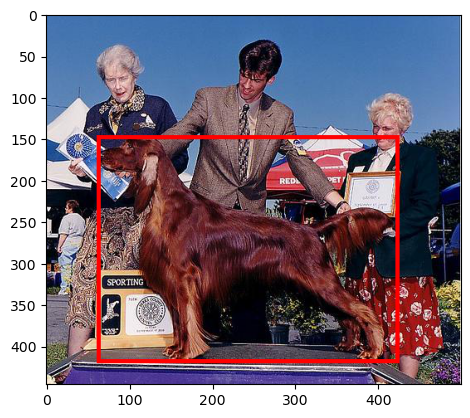

In [92]:
# Display the image using matplotlib
image = train_new[2][0]
plt.imshow(image)
plt.show()

In [93]:
indices = list(range(gan_dataset_len))
np.random.shuffle(indices)
ganDataset = CustomImageDataset(gan_dataset, None, indices, transform, normalize)
g = torch.Generator()
g.manual_seed(42)
gan_sampler = SubsetRandomSampler(indices, generator=g)
CombineDataset = ConcatDataset([train_new, ganDataset])

In [47]:
gan_image = ganDataset[1]

In [94]:
batch_size=32
trainloader = torch.utils.data.DataLoader(ImageDataset, sampler = train_sampler, batch_size=batch_size)
valloader = torch.utils.data.DataLoader(ImageDataset, sampler = val_sampler, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(ImageDataset, sampler = test_sampler, batch_size=batch_size)
ganloader = torch.utils.data.DataLoader(ganDataset, sampler = gan_sampler, batch_size = batch_size)
combloader = torch.utils.data.DataLoader(CombineDataset, batch_size = batch_size, shuffle = True)

In [29]:
def accuracy_test_res(model,loader,criterion):
  correct = 0
  total = 0
  tot_loss = 0
  with torch.no_grad():
      for data in loader:
          images, labels = data
                    
          images = images.float().to(device)
          # labels = labels.float().to(device)

          le = preprocessing.LabelEncoder()
          targets = le.fit_transform(labels)
          targets = torch.as_tensor(targets) 
            
          outputs = model(images)
          
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          predicted = predicted.to(device)
          labels = labels.to(device)
          correct += (predicted == labels).sum().item()
          
          labels = labels.to(torch.int64)
          labels = F.one_hot(labels, num_classes=120).to(torch.float64)

          loss = criterion(outputs, torch.max(labels, 1)[1])

          tot_loss += loss.item()


  Accuracy = 100 * correct / total
  Loss = tot_loss / total
  return Accuracy,Loss

In [30]:
def accuracy_test(model,loader,criterion):
  correct = 0
  total = 0
  tot_loss = 0
  with torch.no_grad():
      for data in loader:
          images, labels = data
                    
          images = images.float().to(device)
          # labels = labels.float().to(device)

          le = preprocessing.LabelEncoder()
          targets = le.fit_transform(labels)
          targets = torch.as_tensor(targets) 
            
#           inputs = image_processor(images, return_tensors="pt")
          outputs = model(images)
          
          _, predicted = torch.max(outputs.logits, 1)
          total += labels.size(0)
          predicted = predicted.to(device)
          labels = labels.to(device)
          correct += (predicted == labels).sum().item()
          
          # outputs = outputs.argmax(1).to(torch.float64)
          labels = labels.to(torch.int64)
          labels = F.one_hot(labels, num_classes=120).to(torch.float64)

          loss = criterion(outputs.logits, torch.max(labels, 1)[1])
#           loss.requires_grad = True
#           loss.backward()
          tot_loss += loss.item()


  Accuracy = 100 * correct / total
  Loss = tot_loss / total
  return Accuracy,Loss


In [31]:
def training_res(model,loader,criterion,optimizer,config,valloader):
  train_acc_arr = []
  train_loss_arr = []
  val_acc_arr = []
  val_loss_arr = []
  y_pred = []
  y_true = []

  for epoch in tqdm(range(config['epochs'])):

    example_ct = 0
    batch_ct = 0
    running_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data

        labels_without_one_hot = labels.float().to(device)
        labels = F.one_hot(labels, num_classes=120)
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)

        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels_without_one_hot).sum().item()

        loss = criterion(outputs, torch.max(labels, 1)[1])
        optimizer.zero_grad()
        # loss.requires_grad = True
        loss.backward()
        optimizer.step()

        example_ct +=  len(inputs)
        batch_ct += 1
        running_loss += loss.item()

        if ((batch_ct) % 100) == 0:
            print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.3f}")
            print(f"Training Accuracy: {100*correct/total}")

    # train_acc, train_loss = accuracy_test(model,trainloader,criterion)
    train_acc = 100*correct/total
    train_loss = running_loss/total
    val_acc,val_loss = accuracy_test_res(model,valloader,criterion)
    print()
    print("VALIDATION ACC",val_acc)
    print("VALIDATION LOSS",val_loss)
    print()
    train_acc_arr.append(train_acc)
    train_loss_arr.append(train_loss)
    val_acc_arr.append(val_acc)
    val_loss_arr.append(val_loss)

  print("Finished training")
  return train_acc_arr,train_loss_arr,val_acc_arr,val_loss_arr

In [32]:
def training(model,loader,criterion,optimizer,config,valloader):
  train_acc_arr = []
  train_loss_arr = []
  val_acc_arr = []
  val_loss_arr = []
  y_pred = []
  y_true = []

  for epoch in tqdm(range(config['epochs'])):

    example_ct = 0
    batch_ct = 0
    running_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data

        labels_without_one_hot = labels.float().to(device)
        labels = F.one_hot(labels, num_classes=120)
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)

#         inputs = image_processor(inputs, return_tensors="pt")
        # labels = labels.argmax(1).to(torch.float64)
        outputs = model(inputs)
        # outputs = torch.argmax(outputs ,axis=1)
        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels_without_one_hot).sum().item()

        loss = criterion(outputs.logits, torch.max(labels, 1)[1])
        optimizer.zero_grad()
        # loss.requires_grad = True
        loss.backward()
        optimizer.step()

        example_ct +=  len(inputs)
        batch_ct += 1
        running_loss += loss.item()

        if ((batch_ct) % 100) == 0:
            print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.3f}")
            print(f"Training Accuracy: {100*correct/total}")

    # train_acc, train_loss = accuracy_test(model,trainloader,criterion)
    train_acc = 100*correct/total
    train_loss = running_loss/total
    val_acc,val_loss = accuracy_test(model,valloader,criterion)
    print()
    print("VALIDATION ACC",val_acc)
    print("VALIDATION LOSS",val_loss)
    print()
    train_acc_arr.append(train_acc)
    train_loss_arr.append(train_loss)
    val_acc_arr.append(val_acc)
    val_loss_arr.append(val_loss)

  print("Finished training")
  return train_acc_arr,train_loss_arr,val_acc_arr,val_loss_arr

In [33]:
# FOR RESNET
def test_res(model, loader):
    model.eval()

    correct, total ,incorrect= 0, 0,0

    y_pred = []
    y_true = []

    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []

    with torch.no_grad():
        for data in loader:
          images, labels = data

          saved_images = images

          images = images.float().to(device)
          # images = torch.transpose(images,-1,1)
          labels = labels.float().to(device)
        
#           inputs = image_processor(images, return_tensors="pt")
            
          outputs = model(images)

          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          predicted = predicted.to(device)
          correct += (predicted == labels).sum().item()

          y_pred.extend(predicted.cpu().numpy())
          y_true.extend(labels.cpu().numpy())
          

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    target_names = ['class 0', 'class 1', 'class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']
    print(classification_report(y_true, y_pred))
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Accuracy of the model on the set of " + f"test images: {correct / total:%}")

    return y_true, y_pred

In [34]:
def test(model, loader):
    model.eval()

    correct, total ,incorrect= 0, 0,0

    y_pred = []
    y_true = []

    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []

    with torch.no_grad():
        for data in loader:
          images, labels = data

          saved_images = images

          images = images.float().to(device)
          # images = torch.transpose(images,-1,1)
          labels = labels.float().to(device)
        
#           inputs = image_processor(images, return_tensors="pt")
            
          outputs = model(images)

          _, predicted = torch.max(outputs.logits, 1)
          total += labels.size(0)
          predicted = predicted.to(device)
          correct += (predicted == labels).sum().item()

          y_pred.extend(predicted.cpu().numpy())
          y_true.extend(labels.cpu().numpy())
          
          # labels = labels.to(torch.int64)
          # labels = F.one_hot(labels, num_classes=10).to(torch.float64)

          # loss = criterion(outputs, labels)
          # loss.requires_grad = True
          # loss.backward()
          # tot_loss += loss.item()

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    target_names = ['class 0', 'class 1', 'class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']
    print(classification_report(y_true, y_pred))
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Accuracy of the model on the set of " + f"test images: {correct / total:%}")

    return y_true, y_pred

In [35]:
from transformers import AutoImageProcessor, ViTForImageClassification
import torch
from datasets import load_dataset

In [36]:
class MobileNetV2(nn.Module):

    def __init__(self, dropout=0.3):

        super(MobileNetV2, self).__init__()

        self.mobile = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights=models.mobilenetv2.MobileNet_V2_Weights.DEFAULT)
        self.mobile.classifier[1] = nn.Linear(1280, 120)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(1000, 120)
        self.soft = nn.Sigmoid()

    def forward(self, images):

        pooled_output = self.mobile(images)
#         pooled_output = pooled_output
#         dropout_output = self.dropout(pooled_output)
#         linear_output = self.linear(dropout_output)
#         final_layer = self.soft(linear_output)

        return pooled_output


In [37]:
class RESNET50(nn.Module):
    def __init__(self, dropout=0.3):

        super(RESNET50, self).__init__()

        self.mobile = models.resnet50(pretrained=True)
        self.mobile.fc = nn.Linear(2048, 120)

    def forward(self, images):

        pooled_output = self.mobile(images)
        return pooled_output

In [38]:
class VITMODEL(nn.Module):

    def __init__(self, dropout=0.3):

        super(VITMODEL, self).__init__()

        self.vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
#         self.dropout = nn.Dropout(dropout)
#         self.linear = nn.Linear(1000, 120)
#         self.soft = nn.Sigmoid()
        self.vit.classifier = nn.Linear(768, 120)

    def forward(self, images):

        pooled_output = self.vit(images)
#         pooled_output = pooled_output.logits
#         dropout_output = self.dropout(pooled_output)
#         linear_output = self.linear(dropout_output)
#         final_layer = self.soft(linear_output)

        return pooled_output

In [39]:
def model_pipeline(hyperparameters, trainloader, valloader, testloader, residual):
    

  model = VITMODEL().to(device)
  # model = CNN().to(device)
#   model = MobileNetV2().to(device)
  model = RESNET50().to(device)

  criterion = nn.CrossEntropyLoss()
  #optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum = 0.9)
  optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

  # and use them to train the model
  train_acc,train_loss,val_acc,val_loss = training(model, trainloader, criterion, optimizer, config, valloader)


  # and test its final performance
  test_true, test_pred = test(model, testloader)


  print("FINISHED")

  return test_true, test_pred,train_acc,train_loss,val_acc,val_loss, model

In [40]:
def model_pipeline_res(hyperparameters, trainloader, valloader, testloader, residual):
    

  #model = VITMODEL().to(device)
  # model = CNN().to(device)
#   model = MobileNetV2().to(device)
  model = RESNET50().to(device)

  criterion = nn.CrossEntropyLoss()
  #optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum = 0.9)
  optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

  # and use them to train the model
  train_acc,train_loss,val_acc,val_loss = training_res(model, trainloader, criterion, optimizer, config, valloader)


  # and test its final performance
  test_true, test_pred = test_res(model, testloader)


  print("FINISHED")

  return test_true, test_pred,train_acc,train_loss,val_acc,val_loss, model

In [41]:
config = dict(
    epochs=10,
    classes=120,
    batch_size=128,
    learning_rate=0.00001,
    dataset="MNIST",
    architecture="CNN")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
  0%|          | 0/10 [00:00<?, ?it/s]

Loss after 03200 examples: 4.029
Training Accuracy: 10.0625
Loss after 06400 examples: 2.954
Training Accuracy: 21.9375
Loss after 09600 examples: 2.363
Training Accuracy: 30.916666666666668
Loss after 12800 examples: 1.767
Training Accuracy: 38.078125
Loss after 16000 examples: 1.999
Training Accuracy: 43.33125


 10%|█         | 1/10 [03:55<35:15, 235.06s/it]


VALIDATION ACC 63.28960155490768
VALIDATION LOSS 0.048127875818107985

Loss after 03200 examples: 1.400
Training Accuracy: 71.90625
Loss after 06400 examples: 1.153
Training Accuracy: 72.859375
Loss after 09600 examples: 0.982
Training Accuracy: 73.30208333333333
Loss after 12800 examples: 0.861
Training Accuracy: 74.0859375
Loss after 16000 examples: 1.065
Training Accuracy: 74.34375


 20%|██        | 2/10 [07:17<28:48, 216.12s/it]


VALIDATION ACC 70.72400388726919
VALIDATION LOSS 0.034211538811698486

Loss after 03200 examples: 1.005
Training Accuracy: 82.46875
Loss after 06400 examples: 0.546
Training Accuracy: 82.328125
Loss after 09600 examples: 0.625
Training Accuracy: 82.40625
Loss after 12800 examples: 0.386
Training Accuracy: 82.2265625
Loss after 16000 examples: 0.760
Training Accuracy: 82.05625


 30%|███       | 3/10 [10:43<24:39, 211.32s/it]


VALIDATION ACC 72.18172983479106
VALIDATION LOSS 0.02978410743415877

Loss after 03200 examples: 0.573
Training Accuracy: 87.375
Loss after 06400 examples: 0.460
Training Accuracy: 87.59375
Loss after 09600 examples: 0.512
Training Accuracy: 87.89583333333333
Loss after 12800 examples: 0.747
Training Accuracy: 87.6796875
Loss after 16000 examples: 0.339
Training Accuracy: 87.675


 40%|████      | 4/10 [14:07<20:50, 208.44s/it]


VALIDATION ACC 72.98347910592808
VALIDATION LOSS 0.028394617473360865

Loss after 03200 examples: 0.254
Training Accuracy: 92.375
Loss after 06400 examples: 0.413
Training Accuracy: 91.890625
Loss after 09600 examples: 0.375
Training Accuracy: 91.70833333333333
Loss after 12800 examples: 0.332
Training Accuracy: 91.703125
Loss after 16000 examples: 0.508
Training Accuracy: 91.53125


 50%|█████     | 5/10 [17:31<17:14, 206.97s/it]


VALIDATION ACC 73.66375121477162
VALIDATION LOSS 0.02768091853088957

Loss after 03200 examples: 0.359
Training Accuracy: 94.8125
Loss after 06400 examples: 0.167
Training Accuracy: 95.109375
Loss after 09600 examples: 0.195
Training Accuracy: 94.89583333333333
Loss after 12800 examples: 0.091
Training Accuracy: 94.6640625
Loss after 16000 examples: 0.252
Training Accuracy: 94.6125


 60%|██████    | 6/10 [20:56<13:45, 206.27s/it]


VALIDATION ACC 73.27502429543246
VALIDATION LOSS 0.028285501997255377

Loss after 03200 examples: 0.185
Training Accuracy: 97.15625
Loss after 06400 examples: 0.086
Training Accuracy: 96.703125
Loss after 09600 examples: 0.137
Training Accuracy: 96.44791666666667
Loss after 12800 examples: 0.107
Training Accuracy: 96.328125
Loss after 16000 examples: 0.233
Training Accuracy: 96.21875


 70%|███████   | 7/10 [24:21<10:16, 205.62s/it]


VALIDATION ACC 73.83381924198251
VALIDATION LOSS 0.028589914126576906

Loss after 03200 examples: 0.145
Training Accuracy: 97.96875
Loss after 06400 examples: 0.099
Training Accuracy: 97.703125
Loss after 09600 examples: 0.099
Training Accuracy: 97.58333333333333
Loss after 12800 examples: 0.182
Training Accuracy: 97.578125
Loss after 16000 examples: 0.122
Training Accuracy: 97.60625


 80%|████████  | 8/10 [27:45<06:50, 205.34s/it]


VALIDATION ACC 72.18172983479106
VALIDATION LOSS 0.030482049158930893

Loss after 03200 examples: 0.106
Training Accuracy: 99.0
Loss after 06400 examples: 0.036
Training Accuracy: 98.9375
Loss after 09600 examples: 0.235
Training Accuracy: 98.72916666666667
Loss after 12800 examples: 0.132
Training Accuracy: 98.59375
Loss after 16000 examples: 0.057
Training Accuracy: 98.49375


 90%|█████████ | 9/10 [31:08<03:24, 204.51s/it]


VALIDATION ACC 72.71622934888241
VALIDATION LOSS 0.031005475615794736

Loss after 03200 examples: 0.068
Training Accuracy: 99.0
Loss after 06400 examples: 0.058
Training Accuracy: 99.078125
Loss after 09600 examples: 0.054
Training Accuracy: 98.98958333333333
Loss after 12800 examples: 0.085
Training Accuracy: 98.8671875
Loss after 16000 examples: 0.082
Training Accuracy: 98.88125


100%|██████████| 10/10 [34:33<00:00, 207.33s/it]


VALIDATION ACC 71.91448007774538
VALIDATION LOSS 0.03196062757276122

Finished training


              precision    recall  f1-score   support

         0.0       0.50      0.60      0.55        10
         1.0       0.83      0.71      0.77        14
         2.0       0.76      0.76      0.76        21
         3.0       0.92      0.65      0.76        17
         4.0       0.84      0.70      0.76        23
         5.0       0.94      0.94      0.94        17
         6.0       1.00      0.94      0.97        18
         7.0       0.64      0.56      0.60        16
         8.0       0.62      0.73      0.67        22
         9.0       1.00      0.96      0.98        27
        10.0       0.94      0.73      0.82        22
        11.0       0.69      0.95      0.80        19
        12.0       0.82      0.88      0.85        16
        13.0       0.93      0.78      0.85        18
        14.0       0.88      0.82      0.85        17
        15.0       0.29      0.45      0.36        11
        16.0       0.64      0.64      0.64        14
        17.0       0.78    

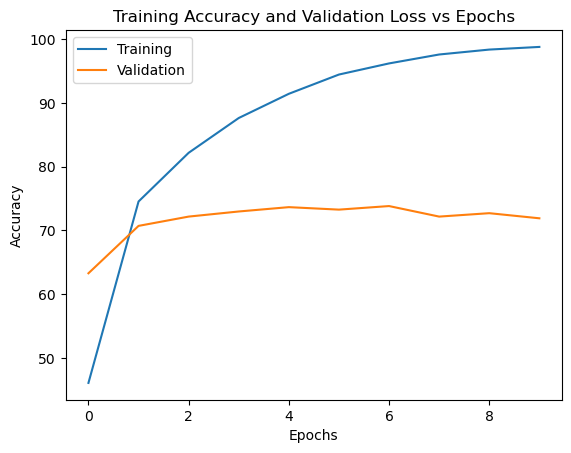

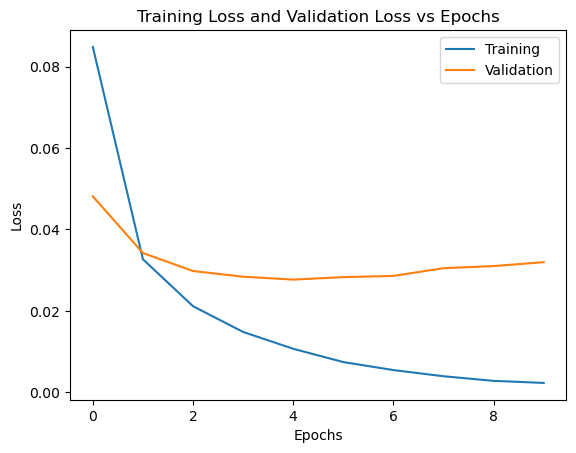

In [68]:
#Mobilenet GAN
test_true, test_pred ,train_acc,train_loss,val_acc,val_loss, model = model_pipeline(config, combloader, valloader, testloader, False)
x = range(config["epochs"])
plt.plot(x,train_acc,label="Training")
plt.plot(x,val_acc,label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Accuracy and Validation Loss vs Epochs")
plt.show()
x = range(config["epochs"])
plt.plot(x,train_loss,label="Training")
plt.plot(x,val_loss,label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss and Validation Loss vs Epochs")
plt.show()
filename = '/resnet50'
pickle.dump(model, open(filename, 'wb'))

In [70]:
%cd /kaggle/working

/kaggle/working


In [80]:
filename = 'ViT_Gan'
pickle.dump(model, open(filename, 'wb'))

  0%|          | 0/10 [00:00<?, ?it/s]

Loss after 03200 examples: 4.375
Training Accuracy: 3.21875
Loss after 06400 examples: 3.880
Training Accuracy: 10.578125
Loss after 09600 examples: 3.389
Training Accuracy: 20.916666666666668
Loss after 12800 examples: 2.570
Training Accuracy: 31.0
Loss after 16000 examples: 2.398
Training Accuracy: 38.93125


 10%|█         | 1/10 [08:15<1:14:22, 495.87s/it]


VALIDATION ACC 75.92322643343051
VALIDATION LOSS 0.06972432985134329

Loss after 03200 examples: 1.720
Training Accuracy: 81.9375
Loss after 06400 examples: 1.709
Training Accuracy: 82.828125
Loss after 09600 examples: 1.217
Training Accuracy: 84.11458333333333
Loss after 12800 examples: 1.147
Training Accuracy: 84.28125
Loss after 16000 examples: 0.976
Training Accuracy: 84.9375


 20%|██        | 2/10 [16:31<1:06:03, 495.50s/it]


VALIDATION ACC 84.98542274052478
VALIDATION LOSS 0.033366427259959565

Loss after 03200 examples: 0.823
Training Accuracy: 92.0
Loss after 06400 examples: 0.792
Training Accuracy: 91.96875
Loss after 09600 examples: 0.775
Training Accuracy: 91.92708333333333
Loss after 12800 examples: 0.655
Training Accuracy: 91.9609375
Loss after 16000 examples: 0.673
Training Accuracy: 92.01875


 30%|███       | 3/10 [24:45<57:45, 495.14s/it]  


VALIDATION ACC 86.46744412050535
VALIDATION LOSS 0.022536467800624634

Loss after 03200 examples: 0.429
Training Accuracy: 95.25
Loss after 06400 examples: 0.275
Training Accuracy: 95.328125
Loss after 09600 examples: 0.225
Training Accuracy: 94.91666666666667
Loss after 12800 examples: 0.267
Training Accuracy: 95.0703125
Loss after 16000 examples: 0.224
Training Accuracy: 95.1125


 40%|████      | 4/10 [32:58<49:25, 494.24s/it]


VALIDATION ACC 86.977648202138
VALIDATION LOSS 0.018616682926755838

Loss after 03200 examples: 0.335
Training Accuracy: 96.8125
Loss after 06400 examples: 0.277
Training Accuracy: 97.109375
Loss after 09600 examples: 0.146
Training Accuracy: 97.09375
Loss after 12800 examples: 0.165
Training Accuracy: 97.1875
Loss after 16000 examples: 0.236
Training Accuracy: 97.03125


 50%|█████     | 5/10 [41:13<41:11, 494.38s/it]


VALIDATION ACC 86.9533527696793
VALIDATION LOSS 0.016794352358672316

Loss after 03200 examples: 0.078
Training Accuracy: 98.53125
Loss after 06400 examples: 0.169
Training Accuracy: 98.3125
Loss after 09600 examples: 0.232
Training Accuracy: 98.26041666666667
Loss after 12800 examples: 0.160
Training Accuracy: 98.3359375
Loss after 16000 examples: 0.064
Training Accuracy: 98.39375


 60%|██████    | 6/10 [49:26<32:55, 493.99s/it]


VALIDATION ACC 86.9290573372206
VALIDATION LOSS 0.016241761548960523

Loss after 03200 examples: 0.071
Training Accuracy: 99.09375
Loss after 06400 examples: 0.077
Training Accuracy: 99.03125
Loss after 09600 examples: 0.071
Training Accuracy: 99.125
Loss after 12800 examples: 0.078
Training Accuracy: 99.1171875
Loss after 16000 examples: 0.063
Training Accuracy: 99.11875


 70%|███████   | 7/10 [57:41<24:42, 494.17s/it]


VALIDATION ACC 86.66180758017492
VALIDATION LOSS 0.015896120071555945

Loss after 03200 examples: 0.030
Training Accuracy: 99.5625
Loss after 06400 examples: 0.033
Training Accuracy: 99.53125
Loss after 09600 examples: 0.032
Training Accuracy: 99.51041666666667
Loss after 12800 examples: 0.045
Training Accuracy: 99.4375
Loss after 16000 examples: 0.030
Training Accuracy: 99.45


 80%|████████  | 8/10 [1:05:58<16:30, 495.15s/it]


VALIDATION ACC 86.49173955296405
VALIDATION LOSS 0.01611140872142753

Loss after 03200 examples: 0.041
Training Accuracy: 99.71875
Loss after 06400 examples: 0.032
Training Accuracy: 99.71875
Loss after 09600 examples: 0.024
Training Accuracy: 99.6875
Loss after 12800 examples: 0.017
Training Accuracy: 99.6171875
Loss after 16000 examples: 0.067
Training Accuracy: 99.6375


 90%|█████████ | 9/10 [1:14:14<08:15, 495.35s/it]


VALIDATION ACC 86.49173955296405
VALIDATION LOSS 0.016207243986536394

Loss after 03200 examples: 0.028
Training Accuracy: 99.84375
Loss after 06400 examples: 0.016
Training Accuracy: 99.859375
Loss after 09600 examples: 0.017
Training Accuracy: 99.82291666666667
Loss after 12800 examples: 0.016
Training Accuracy: 99.8046875
Loss after 16000 examples: 0.036
Training Accuracy: 99.775


100%|██████████| 10/10 [1:22:27<00:00, 494.78s/it]


VALIDATION ACC 86.66180758017492
VALIDATION LOSS 0.016204792421503016

Finished training


              precision    recall  f1-score   support

         0.0       0.75      0.90      0.82        10
         1.0       0.86      0.86      0.86        14
         2.0       0.90      0.86      0.88        21
         3.0       1.00      0.82      0.90        17
         4.0       0.80      0.87      0.83        23
         5.0       0.94      1.00      0.97        17
         6.0       1.00      0.94      0.97        18
         7.0       0.93      0.81      0.87        16
         8.0       0.71      0.91      0.80        22
         9.0       1.00      0.96      0.98        27
        10.0       0.95      0.95      0.95        22
        11.0       0.86      0.95      0.90        19
        12.0       0.88      0.94      0.91        16
        13.0       0.88      0.83      0.86        18
        14.0       0.94      0.88      0.91        17
        15.0       0.44      0.73      0.55        11
        16.0       0.86      0.43      0.57        14
        17.0       0.93    

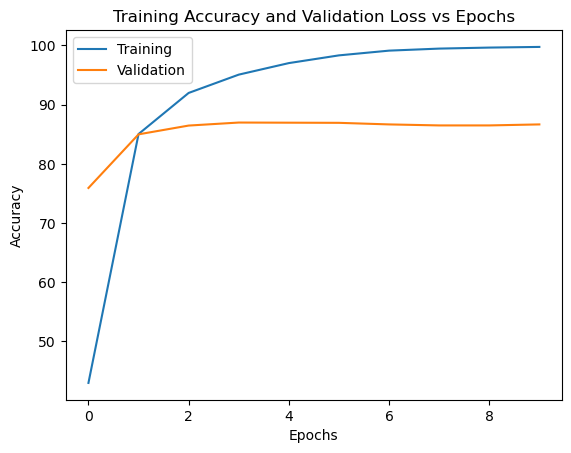

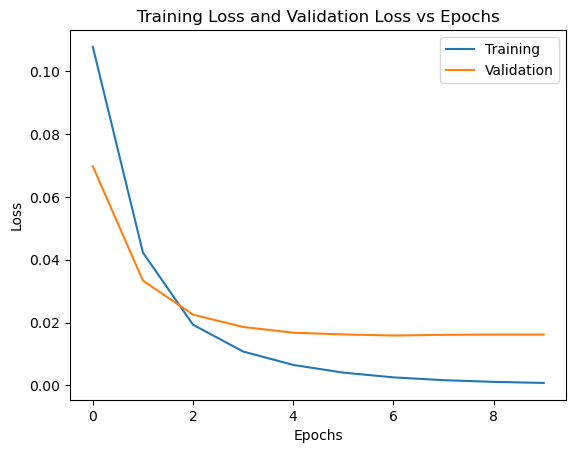

In [79]:
#VIT GAN
test_true, test_pred ,train_acc,train_loss,val_acc,val_loss, model = model_pipeline(config, combloader, valloader, testloader, False)
x = range(config["epochs"])
plt.plot(x,train_acc,label="Training")
plt.plot(x,val_acc,label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Accuracy and Validation Loss vs Epochs")
plt.show()
x = range(config["epochs"])
plt.plot(x,train_loss,label="Training")
plt.plot(x,val_loss,label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss and Validation Loss vs Epochs")
plt.show()
filename = '/resnet50'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
from IPython.display import FileLink
FileLink(r'Resnet50_bounded')

In [ ]:
#RESNET 1e-5 normal
test_true, test_pred ,train_acc,train_loss,val_acc,val_loss, model = model_pipeline_(config, trainloader, valloader, testloader, False)
x = range(config["epochs"])
plt.plot(x,train_acc,label="Training")
plt.plot(x,val_acc,label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Accuracy and Validation Loss vs Epochs")
plt.show()
x = range(config["epochs"])
plt.plot(x,train_loss,label="Training")
plt.plot(x,val_loss,label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss and Validation Loss vs Epochs")
plt.show()
filename = '/resnet50'
pickle.dump(model, open(filename, 'wb'))

  0%|          | 0/10 [00:00<?, ?it/s]

Loss after 03200 examples: 4.433
Training Accuracy: 6.34375
Loss after 06400 examples: 3.998
Training Accuracy: 19.0
Loss after 09600 examples: 3.335
Training Accuracy: 29.322916666666668
Loss after 12800 examples: 3.025
Training Accuracy: 36.03125
Loss after 16000 examples: 2.791
Training Accuracy: 41.425


 10%|█         | 1/10 [04:44<42:44, 284.99s/it]


VALIDATION ACC 65.03887269193392
VALIDATION LOSS 0.07935982021576461

Loss after 03200 examples: 2.152
Training Accuracy: 72.0
Loss after 06400 examples: 1.680
Training Accuracy: 72.953125
Loss after 09600 examples: 1.492
Training Accuracy: 73.77083333333333
Loss after 12800 examples: 1.516
Training Accuracy: 74.8046875
Loss after 16000 examples: 1.408
Training Accuracy: 75.7625


 20%|██        | 2/10 [09:00<35:41, 267.66s/it]


VALIDATION ACC 74.68415937803692
VALIDATION LOSS 0.0466818955479836

Loss after 03200 examples: 1.255
Training Accuracy: 83.3125
Loss after 06400 examples: 1.102
Training Accuracy: 83.40625
Loss after 09600 examples: 0.968
Training Accuracy: 83.83333333333333
Loss after 12800 examples: 0.853
Training Accuracy: 83.8671875
Loss after 16000 examples: 0.692
Training Accuracy: 84.08125


 30%|███       | 3/10 [13:15<30:32, 261.73s/it]


VALIDATION ACC 79.20310981535471
VALIDATION LOSS 0.03355333261170123

Loss after 03200 examples: 0.901
Training Accuracy: 89.125
Loss after 06400 examples: 0.942
Training Accuracy: 89.59375
Loss after 09600 examples: 0.850
Training Accuracy: 89.20833333333333
Loss after 12800 examples: 0.765
Training Accuracy: 89.1953125
Loss after 16000 examples: 0.793
Training Accuracy: 89.21875


 40%|████      | 4/10 [17:28<25:51, 258.56s/it]


VALIDATION ACC 80.02915451895043
VALIDATION LOSS 0.027772701921917144

Loss after 03200 examples: 0.409
Training Accuracy: 92.09375
Loss after 06400 examples: 0.304
Training Accuracy: 92.546875
Loss after 09600 examples: 0.393
Training Accuracy: 92.53125
Loss after 12800 examples: 0.409
Training Accuracy: 92.6484375
Loss after 16000 examples: 0.391
Training Accuracy: 92.55625


 50%|█████     | 5/10 [21:42<21:24, 256.88s/it]


VALIDATION ACC 80.10204081632654
VALIDATION LOSS 0.025164047391873407

Loss after 03200 examples: 0.179
Training Accuracy: 95.71875
Loss after 06400 examples: 0.358
Training Accuracy: 95.140625
Loss after 09600 examples: 0.298
Training Accuracy: 94.96875
Loss after 12800 examples: 0.193
Training Accuracy: 94.984375
Loss after 16000 examples: 0.433
Training Accuracy: 94.8875


 60%|██████    | 6/10 [25:55<17:02, 255.54s/it]


VALIDATION ACC 81.5354713313897
VALIDATION LOSS 0.022989774338242147

Loss after 03200 examples: 0.279
Training Accuracy: 97.0
Loss after 06400 examples: 0.180
Training Accuracy: 96.859375
Loss after 09600 examples: 0.261
Training Accuracy: 96.63541666666667
Loss after 12800 examples: 0.190
Training Accuracy: 96.578125
Loss after 16000 examples: 0.144
Training Accuracy: 96.725


 70%|███████   | 7/10 [30:09<12:44, 254.92s/it]


VALIDATION ACC 82.11856171039844
VALIDATION LOSS 0.021694978208537236

Loss after 03200 examples: 0.101
Training Accuracy: 98.59375
Loss after 06400 examples: 0.109
Training Accuracy: 98.21875
Loss after 09600 examples: 0.117
Training Accuracy: 98.1875
Loss after 12800 examples: 0.134
Training Accuracy: 98.0703125
Loss after 16000 examples: 0.117
Training Accuracy: 98.09375


 80%|████████  | 8/10 [34:24<08:29, 254.85s/it]


VALIDATION ACC 81.17103984450924
VALIDATION LOSS 0.021587141756008156

Loss after 03200 examples: 0.100
Training Accuracy: 99.09375
Loss after 06400 examples: 0.098
Training Accuracy: 99.0
Loss after 09600 examples: 0.115
Training Accuracy: 99.0
Loss after 12800 examples: 0.072
Training Accuracy: 98.9765625
Loss after 16000 examples: 0.049
Training Accuracy: 98.99375


 90%|█████████ | 9/10 [38:38<04:14, 254.84s/it]


VALIDATION ACC 80.97667638483965
VALIDATION LOSS 0.02121238035409629

Loss after 03200 examples: 0.042
Training Accuracy: 99.4375
Loss after 06400 examples: 0.064
Training Accuracy: 99.359375
Loss after 09600 examples: 0.109
Training Accuracy: 99.35416666666667
Loss after 12800 examples: 0.058
Training Accuracy: 99.3359375
Loss after 16000 examples: 0.067
Training Accuracy: 99.35625


100%|██████████| 10/10 [42:52<00:00, 257.27s/it]


VALIDATION ACC 81.12244897959184
VALIDATION LOSS 0.02125379493852862

Finished training


              precision    recall  f1-score   support

         0.0       0.54      0.70      0.61        10
         1.0       0.92      0.86      0.89        14
         2.0       0.94      0.81      0.87        21
         3.0       1.00      0.76      0.87        17
         4.0       0.69      0.78      0.73        23
         5.0       0.84      0.94      0.89        17
         6.0       0.90      1.00      0.95        18
         7.0       0.62      0.62      0.62        16
         8.0       0.69      0.82      0.75        22
         9.0       1.00      0.89      0.94        27
        10.0       0.90      0.82      0.86        22
        11.0       0.79      1.00      0.88        19
        12.0       0.83      0.94      0.88        16
        13.0       0.81      0.72      0.76        18
        14.0       0.94      0.88      0.91        17
        15.0       0.38      0.55      0.44        11
        16.0       0.57      0.57      0.57        14
        17.0       0.80    

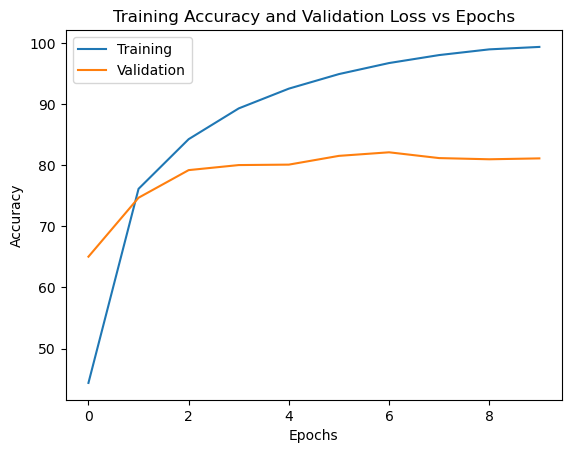

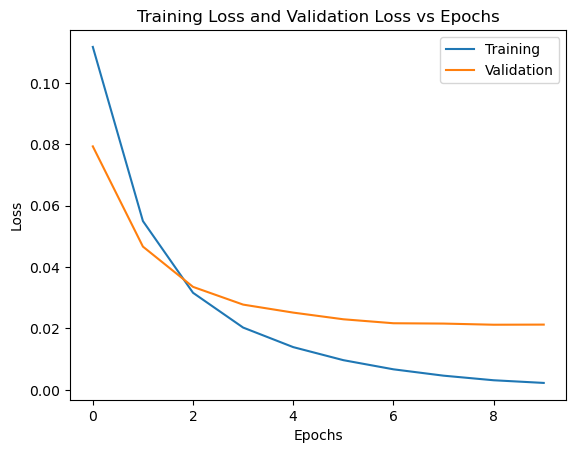

In [43]:
test_true, test_pred ,train_acc,train_loss,val_acc,val_loss, model = model_pipeline_res(config, combloader, valloader, testloader, False)
x = range(config["epochs"])
plt.plot(x,train_acc,label="Training")
plt.plot(x,val_acc,label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Accuracy and Validation Loss vs Epochs")
plt.show()
x = range(config["epochs"])
plt.plot(x,train_loss,label="Training")
plt.plot(x,val_loss,label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss and Validation Loss vs Epochs")
plt.show()
filename = '/resnet50'
pickle.dump(model, open(filename, 'wb'))

In [45]:
%cd /kaggle/working

/kaggle/working


In [46]:
filename = 'Resnet50_gan'
pickle.dump(model, open(filename, 'wb'))

# **Virtal Environment for testing**

In [1]:
import os
import torch
import pickle
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm.auto import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import cv2
from torchvision import models
from sklearn import preprocessing
from tqdm import tqdm
import random
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
from torch.utils.data import Subset
from torch.utils.data import ConcatDataset

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [12]:
annotation = datasets.DatasetFolder('/kaggle/input/stanford-dogs-dataset/annotations/Annotation', loader=load_text_file, extensions=('',))

In [3]:
dataset = datasets.ImageFolder('/kaggle/input/stanford-dogs-dataset/images/Images')
dataset_len = len(dataset)

In [13]:
def load_text_file(path):
        with open(path, 'r') as f:
            text = f.read()
        return text

In [14]:
train_size = int(dataset_len*0.7)
test_size = int(dataset_len*0.1)
val_size = int(dataset_len*0.2)

In [15]:
def train_test_val_split():
  g = torch.Generator()
  g.manual_seed(42)
  indices = list(range(dataset_len))
  np.random.seed(11)
  np.random.shuffle(indices)

  test_index = indices[:test_size]
  train_index = indices[test_size:test_size+train_size]
  val_index = indices[-val_size:]

  train_sampler=SubsetRandomSampler(train_index, generator=g)
  val_sampler=SubsetRandomSampler(val_index, generator=g)
  test_sampler=SubsetRandomSampler(test_index, generator=g)

  return train_sampler,val_sampler,test_sampler,indices, train_index

In [16]:
train_sampler,val_sampler,test_sampler,indices, train_index = train_test_val_split()

In [17]:
class CustomImageDataset(Dataset):
    def __init__(self, dataset, annotation, train_index, transform=None, normalize=None):
        self.dataset = dataset
        self.annotation = annotation
        self.dataset_len = len(dataset)
        self.transform = transform
        self.normalize = normalize
        self.train_index = train_index
        # self.dataset = np.transpose(dataset[0], (1, 2, 0))        

    def __len__(self):
        return self.dataset_len
    
    def load_text_file(path):
        with open(path, 'r') as f:
            text = f.read()
        return text

    def __getitem__(self, idx):
        
        image, index = self.dataset[idx]
        w,h = image.size
        
#         if (idx in self.train_index):
#             text = annotation[idx][0]

#             xml_root = ET.fromstring(text)
            
#             width = int(xml_root.find('size/width').text)
#             height = int(xml_root.find('size/height').text)
#             xmin = int(xml_root.find('object/bndbox/xmin').text)
#             xmax = int(xml_root.find('object/bndbox/xmax').text)
#             ymin = int(xml_root.find('object/bndbox/ymin').text)
#             ymax = int(xml_root.find('object/bndbox/ymax').text)
            
#             bbox = (xmin, ymin, xmax, ymax)

#             annotated_image = Image.new("RGB", (width, height), color=(255, 255, 255))

#             annotated_image.paste(image, (0, 0))

#             draw = ImageDraw.Draw(annotated_image)
#             thickness = 5
#             draw.rectangle(bbox, outline="red", width=thickness)
            
#             image = annotated_image
#             plt.imshow(image)
            
        
        if w < h:
            resized_image = image.resize((224, int(224 * h / w)))
        else:
            resized_image = image.resize((int(224 * w / h), 224))
        w,h = resized_image.size
        image = resized_image.crop((w/2  - 112, h/2 - 112, w/2 + 112, h/2 + 112))
        if self.transform:
            image = self.transform(image)
            image = image.to(torch.float32)
            image = image/255
            image = self.normalize(image)

        label = index

        return image, label

In [18]:
normalize = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
 ])

In [19]:
transform = transforms.Compose([
    transforms.PILToTensor(),
#     transforms.Resize((224, 224)), 
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.RandomHorizontalFlip(0.5),
    # transforms.RandomRotation(degrees = (0,20)),
    # transforms.GaussianBlur(5),
])

In [20]:
ImageDataset = CustomImageDataset(dataset,annotation,train_index, transform, normalize)
train_dataset = Subset(dataset, train_index)
TrainDataset = CustomImageDataset(train_dataset, None, train_index, transform, normalize)

In [22]:
batch_size=32
testloader = torch.utils.data.DataLoader(ImageDataset, sampler = test_sampler, batch_size=batch_size)

In [23]:
def accuracy_test_res(model,loader,criterion):
  correct = 0
  total = 0
  tot_loss = 0
  with torch.no_grad():
      for data in loader:
          images, labels = data
                    
          images = images.float().to(device)
          # labels = labels.float().to(device)

          le = preprocessing.LabelEncoder()
          targets = le.fit_transform(labels)
          targets = torch.as_tensor(targets) 
            
          outputs = model(images)
          
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          predicted = predicted.to(device)
          labels = labels.to(device)
          correct += (predicted == labels).sum().item()
          
          labels = labels.to(torch.int64)
          labels = F.one_hot(labels, num_classes=120).to(torch.float64)

          loss = criterion(outputs, torch.max(labels, 1)[1])

          tot_loss += loss.item()


  Accuracy = 100 * correct / total
  Loss = tot_loss / total
  return Accuracy,Loss

In [24]:
def accuracy_test(model,loader,criterion):
  correct = 0
  total = 0
  tot_loss = 0
  with torch.no_grad():
      for data in loader:
          images, labels = data
                    
          images = images.float().to(device)
          # labels = labels.float().to(device)

          le = preprocessing.LabelEncoder()
          targets = le.fit_transform(labels)
          targets = torch.as_tensor(targets) 
            
#           inputs = image_processor(images, return_tensors="pt")
          outputs = model(images)
          
          _, predicted = torch.max(outputs.logits, 1)
          total += labels.size(0)
          predicted = predicted.to(device)
          labels = labels.to(device)
          correct += (predicted == labels).sum().item()
          
          # outputs = outputs.argmax(1).to(torch.float64)
          labels = labels.to(torch.int64)
          labels = F.one_hot(labels, num_classes=120).to(torch.float64)

          loss = criterion(outputs.logits, torch.max(labels, 1)[1])
#           loss.requires_grad = True
#           loss.backward()
          tot_loss += loss.item()


  Accuracy = 100 * correct / total
  Loss = tot_loss / total
  return Accuracy,Loss


In [25]:
from transformers import AutoImageProcessor, ViTForImageClassification
import torch
from datasets import load_dataset

In [26]:
def test(model, loader):
    model.eval()

    correct, total ,incorrect= 0, 0,0

    y_pred = []
    y_true = []

    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []

    with torch.no_grad():
        for data in loader:
          images, labels = data

          saved_images = images

          images = images.float().to(device)
          # images = torch.transpose(images,-1,1)
          labels = labels.float().to(device)
        
#           inputs = image_processor(images, return_tensors="pt")
            
          outputs = model(images)

          _, predicted = torch.max(outputs.logits, 1)
          total += labels.size(0)
          predicted = predicted.to(device)
          correct += (predicted == labels).sum().item()

          y_pred.extend(predicted.cpu().numpy())
          y_true.extend(labels.cpu().numpy())
          
          # labels = labels.to(torch.int64)
          # labels = F.one_hot(labels, num_classes=10).to(torch.float64)

          # loss = criterion(outputs, labels)
          # loss.requires_grad = True
          # loss.backward()
          # tot_loss += loss.item()

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    target_names = ['class 0', 'class 1', 'class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']
    print(classification_report(y_true, y_pred))
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Accuracy of the model on the set of " + f"test images: {correct / total:%}")

    return y_true, y_pred

In [27]:
# FOR RESNET
def test_res(model, loader):
    model.eval()

    correct, total ,incorrect= 0, 0,0

    y_pred = []
    y_true = []

    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []

    with torch.no_grad():
        for data in loader:
          images, labels = data

          saved_images = images

          images = images.float().to(device)
          # images = torch.transpose(images,-1,1)
          labels = labels.float().to(device)
        
#           inputs = image_processor(images, return_tensors="pt")
            
          outputs = model(images)

          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          predicted = predicted.to(device)
          correct += (predicted == labels).sum().item()

          y_pred.extend(predicted.cpu().numpy())
          y_true.extend(labels.cpu().numpy())
          

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    target_names = ['class 0', 'class 1', 'class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']
    print(classification_report(y_true, y_pred))
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Accuracy of the model on the set of " + f"test images: {correct / total:%}")

    return y_true, y_pred

In [28]:
class VITMODEL(nn.Module):

    def __init__(self, dropout=0.3):

        super(VITMODEL, self).__init__()

        self.vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
#         self.dropout = nn.Dropout(dropout)
#         self.linear = nn.Linear(1000, 120)
#         self.soft = nn.Sigmoid()
        self.vit.classifier = nn.Linear(768, 120)

    def forward(self, images):

        pooled_output = self.vit(images)
#         pooled_output = pooled_output.logits
#         dropout_output = self.dropout(pooled_output)
#         linear_output = self.linear(dropout_output)
#         final_layer = self.soft(linear_output)

        return pooled_output

In [29]:
class RESNET50(nn.Module):
    def __init__(self, dropout=0.3):

        super(RESNET50, self).__init__()

        self.mobile = models.resnet50(pretrained=True)
        self.mobile.fc = nn.Linear(2048, 120)

    def forward(self, images):

        pooled_output = self.mobile(images)
        return pooled_output

In [30]:
class MobileNetV2(nn.Module):

    def __init__(self, dropout=0.3):

        super(MobileNetV2, self).__init__()

        self.mobile = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights=models.mobilenetv2.MobileNet_V2_Weights.DEFAULT)
        self.mobile.classifier[1] = nn.Linear(1280, 120)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(1000, 120)
        self.soft = nn.Sigmoid()

    def forward(self, images):

        pooled_output = self.mobile(images)
#         pooled_output = pooled_output
#         dropout_output = self.dropout(pooled_output)
#         linear_output = self.linear(dropout_output)
#         final_layer = self.soft(linear_output)

        return pooled_output


In [39]:
def model_pipeline_vit(testloader):
  model = pickle.load(open("/kaggle/input/gan-models/ViT_Gan", 'rb'))

  test_true, test_pred = test(model, testloader)


  print("FINISHED")

  return test_true, test_pred

In [41]:
def model_pipeline_res(testloader):
    

  #model = VITMODEL().to(device)
  # model = CNN().to(device)
#   model = MobileNetV2().to(device)
  model = pickle.load(open("/kaggle/input/gan-models/Resnet50_gan", 'rb'))

  test_true, test_pred = test_res(model, testloader)


  print("FINISHED")

  return test_true, test_pred

In [45]:
def model_pipeline_mobile(testloader):
    

  #model = VITMODEL().to(device)
  # model = CNN().to(device)
  model = pickle.load(open("/kaggle/input/gan-models/MobileNet_Gan", 'rb'))

  #model = RESNET50().to(device)

  # and test its final performance
  test_true, test_pred = test_res(model, testloader)


  print("FINISHED")

  return test_true, test_pred

In [46]:
model_pipeline_mobile(testloader)

              precision    recall  f1-score   support

         0.0       0.50      0.60      0.55        10
         1.0       0.83      0.71      0.77        14
         2.0       0.76      0.76      0.76        21
         3.0       0.92      0.65      0.76        17
         4.0       0.84      0.70      0.76        23
         5.0       0.94      0.94      0.94        17
         6.0       1.00      0.94      0.97        18
         7.0       0.64      0.56      0.60        16
         8.0       0.62      0.73      0.67        22
         9.0       1.00      0.96      0.98        27
        10.0       0.94      0.73      0.82        22
        11.0       0.69      0.95      0.80        19
        12.0       0.82      0.88      0.85        16
        13.0       0.93      0.78      0.85        18
        14.0       0.88      0.82      0.85        17
        15.0       0.29      0.45      0.36        11
        16.0       0.64      0.64      0.64        14
        17.0       0.78    

(array([117., 103.,   6., ...,  29.,  30.,  67.], dtype=float32),
 array([117, 103,   6, ...,  29,  30,  67]))

In [42]:
model_pipeline_res(testloader)

              precision    recall  f1-score   support

         0.0       0.54      0.70      0.61        10
         1.0       0.92      0.86      0.89        14
         2.0       0.94      0.81      0.87        21
         3.0       1.00      0.76      0.87        17
         4.0       0.69      0.78      0.73        23
         5.0       0.84      0.94      0.89        17
         6.0       0.90      1.00      0.95        18
         7.0       0.62      0.62      0.62        16
         8.0       0.69      0.82      0.75        22
         9.0       1.00      0.89      0.94        27
        10.0       0.90      0.82      0.86        22
        11.0       0.79      1.00      0.88        19
        12.0       0.83      0.94      0.88        16
        13.0       0.81      0.72      0.76        18
        14.0       0.94      0.88      0.91        17
        15.0       0.38      0.55      0.44        11
        16.0       0.57      0.57      0.57        14
        17.0       0.80    

(array([ 46.,  37.,  68., ..., 102.,  50.,  44.], dtype=float32),
 array([ 46,  37,  68, ..., 102,  50,  44]))

In [40]:
model_pipeline_vit(testloader)

              precision    recall  f1-score   support

         0.0       0.75      0.90      0.82        10
         1.0       0.86      0.86      0.86        14
         2.0       0.90      0.86      0.88        21
         3.0       1.00      0.82      0.90        17
         4.0       0.80      0.87      0.83        23
         5.0       0.94      1.00      0.97        17
         6.0       1.00      0.94      0.97        18
         7.0       0.93      0.81      0.87        16
         8.0       0.71      0.91      0.80        22
         9.0       1.00      0.96      0.98        27
        10.0       0.95      0.95      0.95        22
        11.0       0.86      0.95      0.90        19
        12.0       0.88      0.94      0.91        16
        13.0       0.88      0.83      0.86        18
        14.0       0.94      0.88      0.91        17
        15.0       0.44      0.73      0.55        11
        16.0       0.86      0.43      0.57        14
        17.0       0.93    

(array([ 52.,  99.,  18., ...,  73.,   1., 110.], dtype=float32),
 array([ 52,  98,  18, ...,  73,   5, 110]))